# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no, changed in October by André Brodtkorb

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt
import IPythonMagic
from Timer import Timer
import logging


In [2]:
# CHECK THIS
import pytest
from ipytest import run_pytest, clean_tests

In [3]:
%setup_logging
%cuda_context_handler context

Python version 3.6.6 (default, Sep 12 2018, 18:26:19) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]
Registering context in user workspace
Creating context
PyCUDA version 2018.1.1
CUDA version (9, 1, 0)
Driver version 10000
Using 'Tesla K80' GPU
 => compute capability: (3, 7)
 => memory: 10674 / 11441 MB available
Created context handle <52715520>
Using CUDA cache dir /home/ubuntu/jupyter_notebooks/Stefano_B/MilanoGPU2018/notebooks/cuda_cache


In [4]:
cuda_kernel = """
__global__ void matrixVectorKernel(float* c, float* A, float* b, int a_rows, int a_cols) {
    unsigned int j = blockIdx.x*blockDim.x + threadIdx.x;
    
    //Out of bounds check
    if (j > a_rows) {
        return;
    }
    
    //Compute inner product of row of A with column of B
    float sum = 0.0f;
    for (int i=0; i<a_cols; ++i) {
        unsigned int k = j*a_cols + i;
        sum += A[k] * b[i];
    }
    
    //Write to global memory
    c[j] = sum;
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("matrixVectorKernel");

In [24]:
def gpuMatrixVector(a, b):
    #Upload data to the device
    #NOTE: We need to make sure that a=(a_rows, a_columns)
    # and that b=(a_colmuns, 1) (column vector)
    # and that c=(a_rows, 1)
    with Timer("TIME create", logging.INFO) as t_create:
        a_g = GPUArray(a.shape, np.float32)
        b_g = GPUArray(b.shape, np.float32)
        context.synchronize()

        
    with Timer("TIME allocate", logging.INFO) as t_allocate:
        a_g.set(a)
        b_g.set(b)
        context.synchronize()

    
    #Allocate output data
    c_g = GPUArray(a.shape[0], np.float32)
    
    #NOTE: We need to change this so that the grid*block is x = 1, y = number of rows in A
    block_size = (2, 1, 1) #These need to be [x, y, z]
    grid_size = (int(np.ceil(a.shape[0] / 128)), 1, 1)

    print("Block size is " + str(block_size))
    print("Grid size is " + str(grid_size))
    
    #Execute program on device
    with Timer("TIME kernel", logging.INFO) as t_kernel:
        kernel(c_g, a_g, b_g, np.int32(a.shape[0]), np.int32(a.shape[1]), block=block_size, grid=grid_size)
        context.synchronize()
        
    #Copy data from device to host
    c = np.empty((a.shape[0],1), dtype=np.float32)
    with Timer("TIME download", logging.INFO) as t_get:
        c_g.get(c)
    
    print("GPU code took " + str(t_create.secs) + " seconds")
    print("GPU code took " + str(t_allocate.secs) + " seconds")
    print("GPU code took " + str(t_kernel.secs) + " seconds")
    print("GPU code took " + str(t_get.secs) + " seconds")
    
    # return our computed matrix vector product
    return c

TIME create: 0.511408 ms
TIME allocate: 0.453949 ms
TIME kernel: 0.326872 ms
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x
TIME download: 0.498772 ms


Block size is (2, 1, 1)
Grid size is (1, 1, 1)
GPU code took 0.0005114078521728516 seconds
GPU code took 0.000453948974609375 seconds
GPU code took 0.0003268718719482422 seconds
GPU code took 0.0004987716674804688 seconds


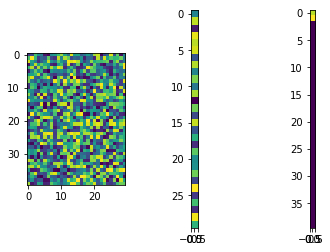

In [26]:
#Size of our test
test_size = (40, 30)

#Create test input / output data
a = np.random.random(test_size).astype(np.float32)
b = np.random.random((test_size[1], 1)).astype(np.float32)
c = gpuMatrixVector(a,b)

fig = plt.figure()
plt.subplot(1,3,1)
plt.imshow(a)
plt.subplot(1,3,2)
plt.imshow(b)
plt.subplot(1,3,3)
plt.imshow(c)
fig.show()

In [20]:
#Compute reference using Numpy
c_ref = np.dot(a, b)

#Sum of absolute differences
sad = np.sum(np.abs(c - c_ref))

#Print result
# print("C   = ", c)
# print("Ref = ", c_ref)
print("Sad = %.30f" % sad)
print("Per element error: " + str(sad / test_size[1]))

Sad = 262.575073242187500000000000000000
Per element error: 8.75250244140625


In [21]:
# Let's define some tests: we create a function starting by "test_"
# clear_tests() # this initializes the pytest framework

def test_fpuMatrixVector():
    
    # Tests a matrix 1x1
    a = np.ones((1,1), dtype=np.float32)
    b = 2*np.ones((1,1), dtype=np.float32)
    c = gpuMatrixVector(a,b)
    assert c == pytest.approx(2.0)
    
    # Test the inner product
    a = np.ones((1,2), dtype=np.float32)
    b = 2*np.ones((2,1), dtype=np.float32)
    c = gpuMatrixVector(a,b)
    assert c == pytest.approx(4.0)
    
    # Test a general matrix
    test_size = (4, 3)
    a = np.random.random(test_size).astype(np.float32)
    b = np.random.random((test_size[1], 1)).astype(np.float32)
    c = gpuMatrixVector(a,b)
    assert c == pytest.approx(np.dot(a,b))

run_pytest(filename='MatrixVectorTestingSingle.ipynb', pytest_options=['-vvv'])

                                                                

============================= test session starts ==============================
platform linux -- Python 3.6.6, pytest-3.8.2, py-1.6.0, pluggy-0.7.1 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /home/ubuntu/jupyter_notebooks/Stefano_B/MilanoGPU2018/notebooks, inifile:
collecting ... collected 1 item

MatrixVectorTestingSingle.py::test_fpuMatrixVector <- <ipython-input-21-a6729241a7a8> 

TIME create: 0.488758 ms
TIME allocate: 0.456333 ms
TIME kernel: 0.132799 ms
TIME download: 0.382662 ms
TIME create: 0.400305 ms
TIME allocate: 0.582695 ms
TIME kernel: 0.110149 ms
TIME download: 0.251055 ms
TIME create: 0.335693 ms
TIME allocate: 0.699997 ms
TIME kernel: 0.110865 ms
TIME download: 0.248671 ms


FAILED [100%]

=================================== FAILURES ===================================
_____________________________ test_fpuMatrixVector _____________________________

    def test_fpuMatrixVector():
    
        # Tests a matrix 1x1
        a = np.ones((1,1), dtype=np.float32)
        b = 2*np.ones((1,1), dtype=np.float32)
        c = gpuMatrixVector(a,b)
        assert c == pytest.approx(2.0)
    
        # Test the inner product
        a = np.ones((1,2), dtype=np.float32)
        b = 2*np.ones((2,1), dtype=np.float32)
        c = gpuMatrixVector(a,b)
        assert c == pytest.approx(4.0)
    
        # Test a general matrix
        test_size = (4, 3)
        a = np.random.random(test_size).astype(np.float32)
        b = np.random.random((test_size[1], 1)).astype(np.float32)
        c = gpuMatrixVector(a,b)
>       assert c == pytest.approx(np.dot(a,b))
E       AssertionError

<ipython-input-21-a6729241a7a8>:23: AssertionError
----------------------------- Captured stdout

1

In [9]:
# SERIAL CODE
with Timer("My Timer Tag 1", logging.INFO) as t:
    np.dot(a,b)
print("Serial code took " + str(t.secs) + " seconds")

# PARALLEL CODE
with Timer("My Timer Tag 2", logging.INFO) as t:
    gpuMatrixVector(a,b)
print("GPU code took " + str(t.secs) + " seconds")

My Timer Tag 1: 0.029564 ms
My Timer Tag 1: 0.572205 ms
My Timer Tag 2: 0.387669 ms
My Timer Tag 3: 0.142574 ms
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x
My Timer Tag 4: 0.469923 ms
My Timer Tag 2: 9.338140 ms


Serial code took 2.956390380859375e-05 seconds
Block size is (128, 1, 1)
Grid size is (1, 1, 1)
GPU code took 0.00057220458984375 seconds
GPU code took 0.0003876686096191406 seconds
GPU code took 0.00014257431030273438 seconds
GPU code took 0.0004699230194091797 seconds
GPU code took 0.009338140487670898 seconds
